# Main

In [1]:
import picamera
from IPython.display import Image
import math
import serial
import socket
import re
import cv2 as cv
import io
import time
import picamera
import numpy as np


IMAGES_PATH = "images/"
utils = "Utils/"

In [14]:
''''''
''' TCP COMMUNICATION with 2nd Raspberry '''
''''''

def enable_tcp_com(BUFFER_SIZE):
    TCP_IP = '192.168.43.58' 
    TCP_PORT = 5005
    while(1):
        try:
            s = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
            s.connect((TCP_IP, TCP_PORT))
            s.setblocking(0)
        except:
            continue
        else:
            print("TCP com enabled!")
            break

    return s

def send_message(s, msg):
    s.send((msg).encode())
    
def check_data_received(s, msg, BUFFER_SIZE):
    ready = select.select([s], [], [], 0.2)
    print(ready)
    if ready[0]:
        data = s.recv(BUFFER_SIZE)
        print(data.decode())
        return data.decode()[-9:] == msg
    else :
        print("Data was not received")
        return None

def close_connection(s):
    s.close()


''''''
''' Robot position: Serial with STM32 '''
''''''


def open_ser():
    ser = serial.Serial(
        port='../../../dev/ttyS0', #Replace ttyS0 with ttyAM0 for Pi1,Pi2,Pi0
        baudrate = 115200,
        parity=serial.PARITY_NONE,
        stopbits=serial.STOPBITS_ONE,
        bytesize=serial.EIGHTBITS,
        timeout=1
    )
    return ser

def get_robot_pos_angle(ser):
    buffer = ''
    ser.flushInput()
    time.sleep(0.1)
    timeout = time.time() + 5 #5s timeout
    while True:
        # last_received = ser.readline()
        buffer += str(ser.read(ser.inWaiting()))
        
        if len(buffer.split('\\n')) >= 3:
            last_received = buffer.split('\\n')[-2]
            pos_angle = re.findall('[+-]?\d+\.\d+', last_received )
            if len(pos_angle) == 3:
                return pos_angle[0], pos_angle[1], pos_angle[2]
        if time.time() > timeout:
            return -1, -1, -1
            break


''''''
''' Bottle position '''
''''''

def calcul_object_pos(xr,yr,ar,dist_rb,a_rb):
    ab = ar + a_rb

    rel_xb = dist_rb * math.cos(math.radians(ab))
    rel_yb = dist_rb * math.sin(math.radians(ab))
    
    real_xb = xr + rel_xb
    real_yb = yr + rel_yb
    return real_xb,real_yb


def calcul_low_center(x,y,w,h):
    return (x+w/2), (y+h)

def multiDimenDist(point1,point2):
   #find the difference between the two points, its really the same as below
    deltaVals = [point2[dimension]-point1[dimension] for dimension in range(len(point1))]
    runningSquared = 0
   #because the pythagarom theorm works for any dimension we can just use that
    for coOrd in deltaVals:
        runningSquared += coOrd**2
    return runningSquared**(1/2)

def findVec(point1,point2,unitSphere = False):
    #setting unitSphere to True will make the vector scaled down to a sphere with a radius one, instead of it's orginal length
    finalVector = [0 for coOrd in point1]
    for dimension, coOrd in enumerate(point1):
        #finding total differnce for that co-ordinate(x,y,z...)
        deltaCoOrd = point2[dimension]-coOrd
        #adding total difference
        finalVector[dimension] = deltaCoOrd
    if unitSphere:
        totalDist = multiDimenDist(point1,point2)
        unitVector =[]
        for dimen in finalVector:
            unitVector.append( dimen/totalDist)
            return unitVector
    else:
        return finalVector

def dotproduct(v1, v2):
    return sum((a*b) for a, b in zip(v1, v2))

def length(v):
    return math.sqrt(dotproduct(v, v))

def calcul_angle(v1, v2):
    return math.acos(dotproduct(v1, v2) / (length(v1) * length(v2)))

def calcul_bottle_dist_angle(center, img_width, img_height):
    vect1 = findVec([img_width/2, img_height],[img_width/2, 0])
    vect2 = findVec([img_width/2, img_height],[center[0],center[1]])
    angle_br = math.degrees(calcul_angle(vect1,vect2))*0.7
    if center[0] > img_width/2:
        angle_br = -angle_br
    dist_y = 20546*(center[1]**(-1.279))
    dist = dist_y / math.cos(math.radians(angle_br))
    return dist, angle_br


''''''
''' Find bottles on image and send their position to Raspberry '''
''''''

def main_process(img):
    robot_x, robot_y, robot_a = get_robot_pos_angle(ser)
    robot_x = float(robot_x)/10
    robot_y = float(robot_y)/10
    robot_a = float(robot_a)
    # resize to increase speed detection
    img_height,img_width = img.shape[:2]   
    start = time.time()
    bottles = bottle_cascade.detectMultiScale(img, minNeighbors=20)
    #print("detection: ", time.time() - start)
    tcp_msg = ""
    msg_to_send = False
    bottle_x = []
    bottle_y = []
    print("bottle number: ", len(bottles))

    for (x,y,w,h) in bottles:
        #cv.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
        #bottomLeftCornerOfText = (x-10,y-10)
        #cv.putText(img,str(i), bottomLeftCornerOfText,font,fontScale,fontColor,lineType)
        center = calcul_low_center(x,y,w,h)
        bottle_dist, bottle_a = calcul_bottle_dist_angle(center, img_width, img_height)
        if bottle_dist < 400:
            cx, cy = calcul_object_pos(robot_x, robot_y, robot_a, 40, bottle_a)
            xb, yb = calcul_object_pos(cx, cy, robot_a, bottle_dist, bottle_a)
            if (xb < 350 and yb > 450) or (xb > 480 and yb > 580) or (xb < 200 and yb < 200) or xb < 10 or yb < 10 or xb > 790 or yb > 790:
                continue
            else:
                msg_to_send = True
                bottle_x.append(int(round(xb)))
                bottle_y.append(int(round(yb)))
        else:
            continue

In [ ]:
BUFFER_SIZE = 1024
s = enable_tcp_com(BUFFER_SIZE)

In [3]:
ser = open_ser()

In [4]:
get_robot_pos_angle(ser)

('4846.26', '16.59', '-3.72')

In [5]:
bottle_cascade = cv.CascadeClassifier(utils + 'biggest_haar.xml')

In [17]:
with picamera.PiCamera() as camera:
    camera.resolution = (504, 336)
    camera.rotation = 180
    camera.framerate = 60
    stream = io.BytesIO()
    for foo in camera.capture_continuous(stream, format='bmp', burst=True):
        # Truncate the stream to the current position (in case
        # prior iterations output a longer image)
        start = time.time()
        stream.truncate()
        stream.seek(0)
        file_bytes = np.asarray(bytearray(stream.read()), dtype=np.uint8)
        
        img = cv.imdecode(file_bytes, cv.IMREAD_COLOR)
        main_process(img)
        stream.seek(0)
        print("total time: ", time.time() - start)
    

cv.imwrite(IMAGES_PATH + "cam_haar.png", img)
Image(filename = IMAGES_PATH + 'cam_haar.png')

bottle number:  0
total time:  0.4938843250274658
bottle number:  0
total time:  0.4833822250366211
bottle number:  0
total time:  0.46100544929504395
bottle number:  0
total time:  0.4584996700286865


KeyboardInterrupt: 

# Haar cascade test

In [18]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import picamera
import time
import re
import cv2 as cv
import os 
import glob
import io
from PIL import Image
from IPython.display import Image as ShowImage
import math
import threading

IMAGES_PATH = "images/"
utils = "Utils/"

bottle_cascade = cv.CascadeClassifier(utils + 'biggest_haar.xml')

font = cv.FONT_HERSHEY_SIMPLEX
fontScale = 1
fontColor = (255,255,255)
lineType = 2

taking picture:  0.5641176700592041
read picture:  0.0043795108795166016
finding bottles:  0.34842371940612793
bottles' number:  0
calcul position of each bottle:  0.0004341602325439453
total processing time: 0.9287071228027344


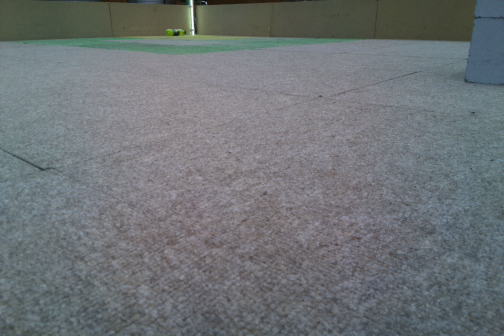

In [20]:
with picamera.PiCamera() as camera:
    camera.resolution = (504, 336)
    camera.rotation = 180
    camera.framerate = 60
    camera.start_preview()
    # Give the camera some warm-up time
    time.sleep(2)
    big_start = time.time()
    start = time.time()
    camera.capture(IMAGES_PATH + "cam.bmp")
    print("taking picture: ", time.time() - start)
    start = time.time()
    img = cv.imread(IMAGES_PATH + 'cam.bmp')
    print("read picture: ", time.time() - start)
    start = time.time()
    img_height, img_width = img.shape[:2] 
    bottles = bottle_cascade.detectMultiScale(img, minNeighbors=10)
    print("finding bottles: ", time.time() - start)
    i = 0
    start = time.time()
    for (x,y,w,h) in bottles:
        cv.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
        bottomLeftCornerOfText = (x-10,y-10)
        cv.putText(img,str(i), bottomLeftCornerOfText,font,fontScale,fontColor,lineType)
        center = calcul_low_center(x,y,w,h)
        dist, angle = calcul_bottle_dist_angle(center, img_width, img_height)
        cv.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
        i = i + 1
    print("bottles' number: ", i)
    print("calcul position of each bottle: ", time.time() - start)
    print("total processing time:", time.time() - big_start)
cv.imwrite(IMAGES_PATH + "cam_haar.png", img)
ShowImage(filename = IMAGES_PATH + 'cam_haar.png')

# Recording video

In [27]:
import datetime
def record_video():
    filename = "recording_" + str(datetime.datetime.now().strftime("%Y%m%d_%H%M%S")) + ".h264"
    camera.start_preview()
    camera.start_recording(filename)

def finish_video():
    camera.stop_recording()
    camera.stop_preview()

record_video()
time.sleep(60)
finish_video()

KeyboardInterrupt: 

# Close connection and camera, + checkpoints

In [20]:
camera.close()

In [9]:
close_connection(s)

In [ ]:
[[1000,2600,0],[6500,2600,0],[6500,5000,0],[4500,5000,0],[4500,7500,0],[3800,7500,0],[3800,5500,0],[7500,5500,0],[7500,500,0],[2500,500,0],[2500,4000,0],[7000,4000,0],[7000,1500,0],[3500,1500,0],[700,3500,0],[5500,3500,0],[5500,4200,0],[700,4200,0]]